In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.legacy import Adam


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/sugarcane RA",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 375 files belonging to 4 classes.


In [5]:
print(dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [6]:
class_names=dataset.class_names
class_names

['Bacterial Blight', 'Healthy', 'Red Rot', 'RedRust']

In [7]:
len(dataset)

12

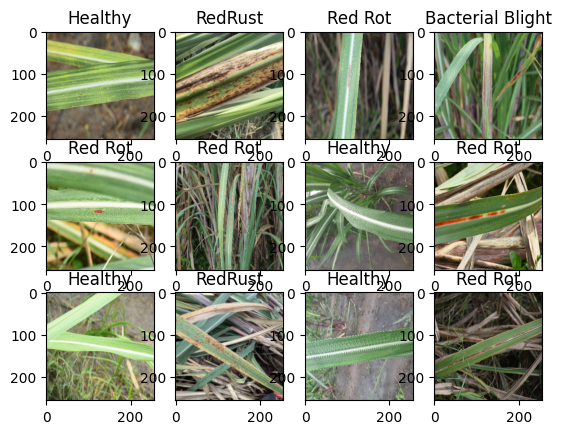

In [ ]:
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])

  
  

In [8]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  # val_size=val_size+1
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)

In [10]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

9
1
2


In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [13]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=4
model=models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
9/9 [==============================] - 284s 15s/step - loss: 1.3849 - accuracy: 0.2688 - val_loss: 1.3873 - val_accuracy: 0.2500
Epoch 2/20
9/9 [==============================] - 45s 5s/step - loss: 1.3742 - accuracy: 0.2796 - val_loss: 1.4064 - val_accuracy: 0.2500
Epoch 3/20
9/9 [==============================] - 44s 5s/step - loss: 1.3703 - accuracy: 0.2975 - val_loss: 1.3634 - val_accuracy: 0.2812
Epoch 4/20
9/9 [==============================] - 45s 5s/step - loss: 1.3407 - accuracy: 0.3333 - val_loss: 1.2816 - val_accuracy: 0.5000
Epoch 5/20
9/9 [==============================] - 43s 5s/step - loss: 1.3067 - accuracy: 0.3333 - val_loss: 1.1960 - val_accuracy: 0.5000
Epoch 6/20
9/9 [==============================] - 42s 5s/step - loss: 1.1484 - accuracy: 0.4875 - val_loss: 0.8630 - val_accuracy: 0.5625
Epoch 7/20
9/9 [==============================] - 44s 5s/step - loss: 1.3659 - accuracy: 0.3441 - val_loss: 1.1460 - val_accuracy: 0.3438
Epoch 8/20
9/9 [================

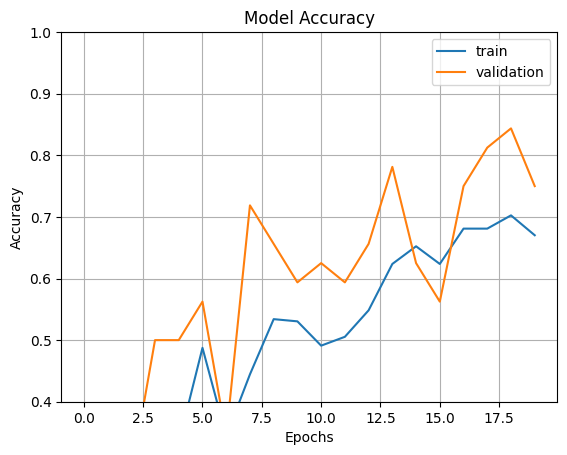

In [17]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
model.evaluate(test_ds)

2/2 [==============================] - 61s 2s/step - loss: 0.6575 - accuracy: 0.7344


[0.6575139760971069, 0.734375]

In [ ]:
import numpy as np
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  pred=model.predict(img_array)
  predict_class=class_names[np.argmax(pred[0])]
  confidence=round(100*(np.max(pred[0])),2)
  return predict_class,confidence

1/1 [==============================] - 0s 51ms/step


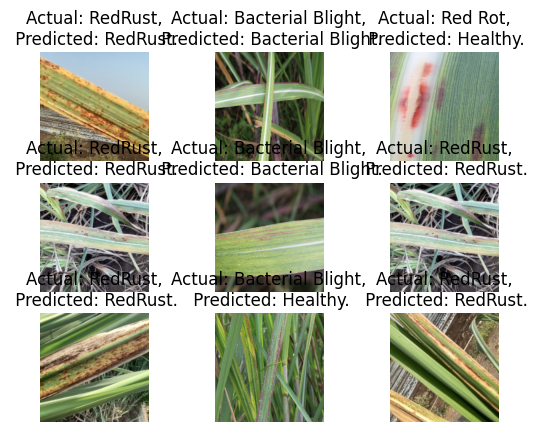

In [ ]:
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predict_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predict_class}.")
    
    plt.axis("off")

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
model.save('sugarcane_cnn')

In [ ]:
loaded_1 = tf.keras.models.load_model(
    "sugarcane_cnn")

In [ ]:
import numpy as np
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  pred=loaded_1.predict(img_array)
  predict_class=class_names[np.argmax(pred[0])]
  confidence=round(100*(np.max(pred[0])),2)
  return predict_class,confidence

In [ ]:
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predict_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predict_class},\n Confidence{confidence}.")
    
    plt.axis("off")

In [ ]:
tf.keras.models.save_model(model,'/content/drive/MyDrive/sugarcane1.h5')

In [ ]:
loaded=tf.keras.models.load_model('/content/drive/MyDrive/sugarcane1.h5')

In [ ]:
import numpy as np
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  pred=loaded.predict(img_array)
  predict_class=class_names[np.argmax(pred[0])]
  confidence=round(100*(np.max(pred[0])),2)
  return predict_class,confidence

In [ ]:
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predict_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predict_class},\n Confidence{confidence}.")
    
    plt.axis("off")

In [ ]:
loaded.evaluate(test_ds)

2/2 [==============================] - 4s 2s/step - loss: 0.6575 - accuracy: 0.7344


[0.6575139760971069, 0.734375]

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()